In [ ]:
(notebook_name)=
# 2.1 Building a Bayesian model for events

:::{post} March 21, 2022
:tags: python
:category: beginner
:author: Lode Nachtergaele
:::

<a href="https://github.com/pymc-devs/resources/blob/main/bayesrules/Section_2_1_Fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyreadr
!pip install wget
!pip install pymc3
!pip install arviz

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import wget
import pyreadr
import seaborn as sns

In [ ]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# !wget -O fake_news.rda https://github.com/bayes-rules/bayesrules/blob/master/data/fake_news.rda?raw=true

--2022-03-21 11:35:36--  https://github.com/bayes-rules/bayesrules/blob/master/data/fake_news.rda?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/bayes-rules/bayesrules/raw/master/data/fake_news.rda [following]
--2022-03-21 11:35:37--  https://github.com/bayes-rules/bayesrules/raw/master/data/fake_news.rda
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bayes-rules/bayesrules/master/data/fake_news.rda [following]
--2022-03-21 11:35:37--  https://raw.githubusercontent.com/bayes-rules/bayesrules/master/data/fake_news.rda
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connecte

In [4]:
fake_news_url = r'https://github.com/bayes-rules/bayesrules/blob/master/data/fake_news.rda?raw=true'  
wget.download(fake_news_url, 'fake_news.rda')
try:
    result = pyreadr.read_r('fake_news.rda')
except FileNotFoundError:
    print('Could not read R data file fake_news.rda')

In [5]:
df = result['fake_news']

In [6]:
df.head()

,title,text,url,authors,type,title_words,text_words,title_char,text_char,title_caps,...,disgust,fear,joy,sadness,surprise,trust,negative,positive,text_syllables,text_syllables_per_word
0,Clinton's Exploited Haiti Earthquake ‘to Steal...,0 SHARES Facebook Twitter\n\nBernard Sansaricq...,http://freedomdaily.com/former-haitian-senate-...,NaN,fake,17,219,110,1444,0,...,2.54,3.81,1.27,4.66,2.12,2.97,8.47,3.81,395,1.803653
1,Donald Trump Jr. Just Pinned A Tweet So Stupid...,\n\nPosted by Frank Wilkenmeyer on 19 Sep 2016...,http://winningdemocrats.com/donald-trump-jr-ju...,NaN,real,18,509,95,3016,0,...,1.90,1.90,1.71,1.33,1.14,4.17,4.74,4.93,845,1.660118
2,Michelle Obama NOT Leaving The White House – H...,Michelle Obama NOT Leaving The White House – H...,http://rightwingnews.com/top-news/michelle-oba...,Sierra Marlee,fake,16,494,96,2881,1,...,0.98,1.57,1.96,0.78,1.18,3.73,3.33,5.49,806,1.631579
3,Trump hits Clinton on Islamic State: ‘It is ti...,"“Crooked Hillary has been fighting ISIS, or wh...",http://politi.co/2cEsAnL,"Jack Shafer,Nolan D",real,11,268,60,1674,0,...,1.79,4.30,0.36,1.79,1.79,2.51,6.09,2.15,461,1.720149
4,Australia Voted To Ban Muslims And Liberals Ar...,When Donald Trump said that he wanted to ban M...,https://goo.gl/p7jFZG,Blair Patterson,fake,9,479,54,2813,0,...,0.41,0.82,1.23,0.82,0.82,2.46,2.66,4.30,761,1.588727


In [7]:
pd.concat([df['type'].value_counts().rename('n'), df['type'].value_counts(normalize=True).rename('percent')], axis=1)

,n,percent
real,90,0.6
fake,60,0.4


In [8]:
pd.crosstab(df['title_has_excl'], df['type'], margins=True)

type,fake,real,All
title_has_excl,,,
False,44,88,132
True,16,2,18
All,60,90,150


In [9]:
article = pd.Series(["real", "fake"], dtype="category")

In [10]:
prior = pd.Series([0.6, 0.4])

In [11]:
df_sample = pd.DataFrame({'type': article, 'weights' : prior})

In [12]:
df_sample.sample(3, replace=True, random_state=1301, weights='weights')

,type,weights
0,real,0.6
1,fake,0.4
0,real,0.6


In [13]:
article_sim = df_sample.sample(10_000, replace=True, random_state=84735, weights='weights')

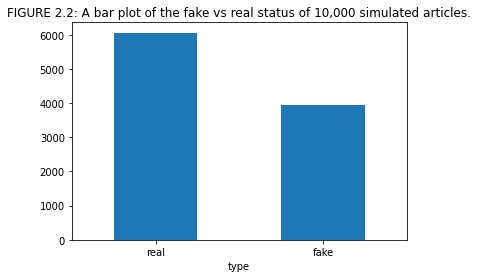

In [14]:
ax = article_sim['type'].value_counts().plot.bar(rot=0);
ax.set_xlabel('type');
ax.set(title='FIGURE 2.2: A bar plot of the fake vs real status of 10,000 simulated articles.');

In [15]:
article_sim['type'].value_counts()

real    6062
fake    3938
Name: type, dtype: int64

In [16]:
article_sim['data_model'] = article_sim['type'].map({'fake': 0.2667, 'real':0.0222})
article_sim.head()

,type,weights,data_model
0,real,0.6,0.0222
1,fake,0.4,0.2667
1,fake,0.4,0.2667
1,fake,0.4,0.2667
1,fake,0.4,0.2667


In [18]:
N_fake = (article_sim['type']=='fake').sum() # The number of artices that are fake
N_real = (article_sim['type']=='real').sum() # The number of artices that are real
article_sim.loc[article_sim['type']=='fake', 'usage'] = np.random.choice(['no', 'yes'], size=N_fake, replace=True, p=[1-0.2667, 0.2667])
article_sim.loc[article_sim['type']=='real', 'usage'] = np.random.choice(['no', 'yes'], size=N_real, replace=True, p=[1-0.0222, 0.0222])

In [19]:
pd.crosstab(article_sim['usage'], article_sim['type'], margins=True)

type,fake,real,All
usage,,,
no,2874,5929,8803
yes,1064,133,1197
All,3938,6062,10000


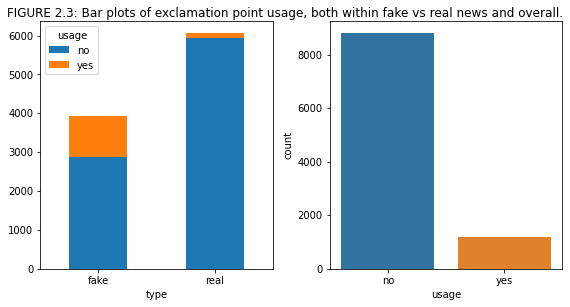

In [20]:
fix, ax = plt.subplots(1, 2, figsize=(8, 4.5))
pd.crosstab(article_sim['type'], article_sim['usage']).plot(kind='bar', stacked=True, rot=0, ax=ax[0]);
sns.countplot(x='usage', data=article_sim, ax=ax[1]);
# article_sim['usage'].value_counts().plot.bar(rot=0, ax=ax[1]);
plt.suptitle('FIGURE 2.3: Bar plots of exclamation point usage, both within fake vs real news and overall.');
plt.subplots_adjust(top=0.15)
plt.tight_layout();

In [21]:
# ax = article_sim['usage'].value_counts().plot.bar(rot=0);
# ax.set_xlabel('usage');

In [22]:
# sns.catplot(x='usage', kind='count', data=article_sim);

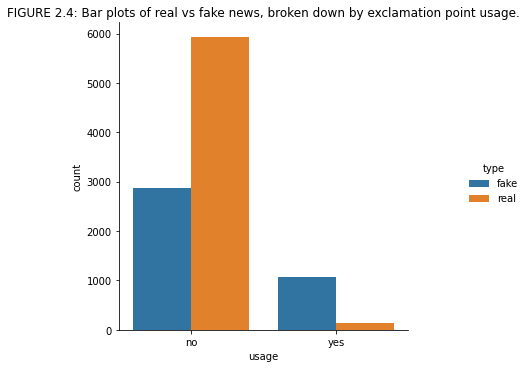

In [23]:
sns.catplot(x='usage', hue='type', data=article_sim, kind='count');
plt.title('FIGURE 2.4: Bar plots of real vs fake news, broken down by exclamation point usage.');

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p wget, pyreadr, pandas, matplotlib, seaborn

In [ ]:
:::{include} ../page_footer.md
:::